In [1]:
%%time
#print("1")
import tensorflow as tf
from numba import cuda
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
from keras.preprocessing.sequence import pad_sequences
#print("2")
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
import pickle
from keras.layers import Dense, Input, Dropout
from keras import Sequential
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import keras
from sklearn.model_selection import train_test_split
from keras.constraints import maxnorm
import numpy as np
from sklearn.metrics import roc_auc_score

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5058569731859551109
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 17432657080112918623
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 23231750620979664
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15870492672
locality {
  bus_id: 1
  links {
  }
}
incarnation: 165579305959611017
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


Using TensorFlow backend.


CPU times: user 3.6 s, sys: 1.2 s, total: 4.81 s
Wall time: 11.1 s


In [2]:
def plot_history(history):
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    auc = history.history['auc']
    val_auc = history.history['val_auc']
    x = range(1, len(accuracy) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 3, 1)
    plt.plot(x, accuracy, 'b', label='Training accuracy')
    plt.plot(x, val_accuracy, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 3, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.subplot(1, 3, 3)
    plt.plot(x, auc, 'b', label='Training auc')
    plt.plot(x, val_auc, 'r', label='Validation auc')
    plt.title('Training and validation auc')
    plt.legend()

In [3]:
%%time

with open(r"../input/challengedadata/comments.txt", "rb") as f:
    clean_train_comments = pickle.load(f) 
    f.close()

with open(r"../input/challengedadata/targets.txt", "rb") as ft:
    y= pickle.load(ft) 
    ft.close()

    
y = [int(s) for s in y]

# # alternaticve tokenization. The obvious relation between num_words and vocab_sizet (the should be equal) is here not satisfied. As we don't understand it, we will not use it.
# from keras.preprocessing.text import Tokenizer
# tokenizer = Tokenizer(num_words=5000)
# # train tokenizer (bow model)
# tokenizer.fit_on_texts(clean_train_comments)
# vocab_sizet = len(tokenizer.word_index) + 1
# print(vocab_sizet)
# # X will be the array of bows
# Xt = tokenizer.texts_to_sequences(clean_train_comments)
# maxlent = max([len(x) for x in Xt])
# Xt_pad = pad_sequences(Xt, padding='post', maxlen=maxlent)
# print("done with tokenizer")
## end of alternaticve tokenization

# # standard scaler on keras tokenizer
# print("ss on tokenizer")
# scaler = StandardScaler(with_mean=False)
# Xt_pad_scal = scaler.fit_transform(Xt_pad)
# # end of scaler on keras tokenizer

#tfidf vectorization
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

clean_train,clean_valid,y_train,y_valid = train_test_split(clean_train_comments,y, train_size = 0.8, test_size = 0.2, random_state = 0)
# clean_train = np.array(clean_train)
# clean_valid = np.array(clean_valid)
# We transform each complaint into a vector
print("training tfidf and vectorizing train")
X_train = tfidf.fit_transform(clean_train).toarray() #clean-train_comments # as this: https://stats.stackexchange.com/questions/154660/tfidfvectorizer-should-it-be-used-on-train-only-or-traintest   and this: https://stackoverflow.com/questions/47778403/computing-tf-idf-on-the-whole-dataset-or-only-on-training-data suggest,train tfidf only on training set
vocab_size = len(tfidf.vocabulary_) + 1
print("vocab_size = ", vocab_size)
print("evaluating maxlen")
# evaluate max len train data
maxlen_train = max([len(x) for x in X_train])
# pad train data accordingly
print("padding")
X_train_pad =  pad_sequences(X_train, padding='post', maxlen=maxlen_train, dtype='float32') 
#train scaler
print("training scaler and scaling train")
scaler = StandardScaler(with_mean=False)
X_train_pad_scal = scaler.fit_transform(X_train_pad)
print("preparing validation set. Vectorizing...")
X_valid = tfidf.transform(clean_valid).toarray()
print("padding...")
X_valid_pad = pad_sequences(X_valid, padding='post', maxlen=maxlen_train, dtype='float32') 
print("scaling...")
X_valid_pad_scal = scaler.transform(X_valid_pad)


print("saving1")
with open("../working/X_train_pad_scal.txt", "wb") as f:
    pickle.dump(X_train_pad_scal,f)
    f.close()
    
print("saving2")
with open("../working/X_valid_pad_scal.txt", "wb") as f:
    pickle.dump(X_valid_pad_scal,f)
    f.close()


print("saving2")
with open("../working/y.txt", "wb") as f:
    pickle.dump(y,f)
    f.close()

training tfidf and vectorizing train
vocab_size =  94695
evaluating maxlen
padding
training scaler and scaling train
preparing validation set. Vectorizing...
padding...
scaling...
saving1
saving2
saving2
CPU times: user 34.8 s, sys: 7.4 s, total: 42.2 s
Wall time: 43 s


In [4]:
# Define the models.

def model0():  # from https://medium.com/@am.benatmane/keras-hyperparameter-tuning-using-sklearn-pipelines-grid-search-with-cross-validation-ccfc74b0ce9f

    METRICS = [ 
          tf.keras.metrics.BinaryAccuracy(name='accuracy'),
          tf.keras.metrics.AUC(name='auc'),
    ]

    optimizer="Adamax" #"adam"
    dropout=0.3 #0.2
    init= "uniform" #"normal"#'he_uniform' #"uniform"
    nbr_features= vocab_size-1 #2500
    dense_nparams= 256 #128 #512 #256

    model = Sequential()
    model.add(Dense(dense_nparams, activation='softsign', input_shape=(nbr_features,), kernel_initializer=init,  kernel_constraint=maxnorm(3))) #3 # maxnorm(0) & softmax & sigmoid -> 0.89 # maxnorm(0) & softmax & softmax -> 0.5  maxnorm(2) & relu & sigmoid ->0.92  maxnorm(1) & relu & sigmoid ->0.82
    model.add(Dropout(dropout))
    model.add(Dense(1, activation='sigmoid')) #'sigmoid' # relu & "softmax" fa 0.5-> non va bene  #' relu & softplus' -> 0.75 
    model.compile(loss='binary_crossentropy', optimizer=optimizer,metrics = METRICS)
    return model
    

In [5]:
class MyCustomCallback(tf.keras.callbacks.Callback):
    
    def on_epoch_end(self,epoch, logs=None):
        y_pred = model.predict_proba(X_valid_pad, batch_size = 1)
        print("roc evaluated with scikit = ",roc_auc_score(y_valid, y_pred))
        return
    

Train on 4000 samples, validate on 1000 samples
Epoch 1/5
4000/4000 [==============================] - 5s 1ms/step - loss: 0.4983 - accuracy: 0.7364 - auc: 0.6594 - val_loss: 0.4183 - val_accuracy: 0.7659 - val_auc: 0.7939
roc evaluated with scikit =  0.8653810863714215
Epoch 2/5
4000/4000 [==============================] - 3s 845us/step - loss: 0.2739 - accuracy: 0.8057 - auc: 0.8562 - val_loss: 0.3829 - val_accuracy: 0.8293 - val_auc: 0.8868
roc evaluated with scikit =  0.8746278851643423
Epoch 3/5
4000/4000 [==============================] - 3s 827us/step - loss: 0.1594 - accuracy: 0.8492 - auc: 0.9094 - val_loss: 0.3881 - val_accuracy: 0.8634 - val_auc: 0.9239
roc evaluated with scikit =  0.8762539760215315
Epoch 4/5
4000/4000 [==============================] - 3s 854us/step - loss: 0.0941 - accuracy: 0.8759 - auc: 0.9355 - val_loss: 0.3943 - val_accuracy: 0.8854 - val_auc: 0.9435
roc evaluated with scikit =  0.8743526221352256
Epoch 5/5
4000/4000 [==============================] -

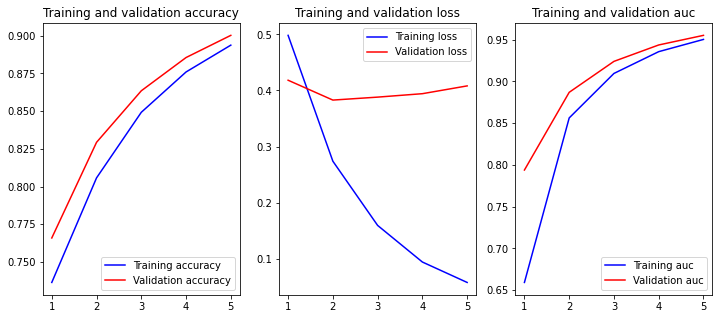

In [6]:
%%time
# early stopping
callbacks = EarlyStopping(
        monitor='val_loss', # val_accuracy
        min_delta=1e-2,
        patience=2, #2
        verbose=10)


model = model0()

history = model.fit(x=X_train_pad, y=y_train, batch_size = 16, epochs = 5, verbose=1,validation_data = (X_valid_pad,y_valid), callbacks=[MyCustomCallback()], shuffle=True, validation_freq=1, max_queue_size=10, workers=4, use_multiprocessing=True) #, callbacks=callbacks , validation_split=0.2
plot_history(history)



# reset gpu memory https://stackoverflow.com/a/60354785/13110508 (but be warned: it crashes python, so use it just at the end)
# device = cuda.get_current_device()
# device.reset()